In [2]:
# Import chunk of things
import xarray as xr
import matplotlib.dates as mdates
import numpy as np
import matplotlib
from matplotlib import rcParams
import datetime
import pandas as pd
import cftime
import pylab as plt
import netCDF4 as nc
from numpy import ma
import dask as dd
from matplotlib.colors import LinearSegmentedColormap,ListedColormap
from matplotlib import cm

## Map Plotting imports

from matplotlib.colors import LinearSegmentedColormap,ListedColormap
from matplotlib import cm
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

#stash codes
stash_ch4 = 'mass_fraction_of_methane_in_air'
stash_co = 'mass_fraction_of_carbon_monoxide_in_air'
stash_ch4_oh = 'm01s50i041'
stash_oh = 'mass_fraction_of_hydroxyl_radical_in_air'
stash_o3 = 'mass_fraction_of_ozone_in_air'
stash_trop = 'm01s50i062'
stash_mass = 'm01s50i063'
stash_temp = 'surface_temperature'
stash_nox = 'm01s50i081'
stash_ems = 'm01s50i306'

#define functions
def molec_cm3(conc_kg_kg, mass, vol, mr):
    molec_box = conc_kg_kg*mass/mr*1000*n_a #molecules per box
    cm3 = molec_box/(vol*1e6) #molec per cm3
    return cm3

def moving_average(x, months):
    return np.convolve(x, np.ones(months), 'valid') / months

n_a = 6.02e23

In [3]:
# Lat area scaling value and volume data
area = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/areacella_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc')
box_area = area.areacella

total_area = np.sum(box_area)
area_scaled = box_area/total_area
lat_area_scaled = area_scaled[:,0]#1D array of latitude scaling values

data_alt = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/vol_n96.nc')
vol = data_alt.grid_cell_volume
vol = vol.data

In [4]:
# Import required data
ch4_data_1 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/ubl949_ch4_PI.nc',chunks={'time':24})
ch4_1 = ch4_data_1.variables[stash_ch4][:]
time_1 = ch4_data_1.time

airm_data = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/ubl949_airmass_PI.nc',chunks={'time':24})
airm = airm_data.variables[stash_mass]

In [5]:
from eofs.standard import Eof
# Set inp = data in kg kg-1
# airm = airmass used
# mr = mr of species considered

inp = ch4_1
lat = ch4_data_1.latitude
lon = ch4_data_1.longitude
mr_u = 16

# trop mask on data
o3 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/ubl949_o3_PI_run.nc',  chunks = {'time': 24})
o3['mask'] = xr.ones_like(o3.mass_fraction_of_ozone_in_air)
o3['mask'] = o3.mask.where(o3.mass_fraction_of_ozone_in_air<7.544e-8,other=0.)

# calculate trop mean
conc = molec_cm3(inp,airm,vol,mr_u)
trop_conc = dd.array.average(conc,weights=o3.mask,axis=(1))

# define weights then create a grid of scaled values with sqrt(cos(latitude))
weight_lat = np.abs(np.cos(lat))
weight_grid_lonlat = np.tile(weight_lat,(192,1))
w_use = weight_grid_lonlat.transpose()

# for some reason doesn't like to do the analysis on the dask array, gives an error about missing values and wrong size matrices, but computing into a numpy array works fine
data = trop_conc.compute()

# eof analysis
solver = Eof(data,weights=w_use)

eofs = solver.eofsAsCorrelation(neofs=5)
pcs = solver.pcs(npcs=5,pcscaling=1)
# outputs eofs and pcs to be used

In [6]:
## Plot temperature in NINO3.4

temp_data_949 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/ubl949_surface_temp_apm.nc')
temp_949 = temp_data_949.surface_temperature
lat = temp_data_949.latitude
lon = temp_data_949.longitude
time_949 = temp_data_949.time

# apply nino3.4 mask to data
temp_data_949['mask'] = xr.ones_like(temp_949)
temp_data_949['mask'] = temp_data_949.mask.where(np.abs(temp_949.latitude)<5,other=0.) 
temp_data_949['mask'] = temp_data_949.mask.where(temp_949.longitude<240,other=0.)
temp_data_949['mask'] = temp_data_949.mask.where(temp_949.longitude>190,other=0.)
enso_949 = ma.masked_where(temp_data_949.mask!=1,temp_949)
nino_mean_949 = np.mean(enso_949,axis=(1,2))

## calculate 3 month mean for enso data

bl949_3monmean = moving_average(nino_mean_949,3)
bl949_30yrmean = moving_average(nino_mean_949,360)

temp_anomaly_bl949 = bl949_3monmean[357:] - bl949_30yrmean

dtime_949 = nc.date2num(time_949[357:],'days since 2000-01-01 00:00:00',calendar='360_day',has_year_zero=True)

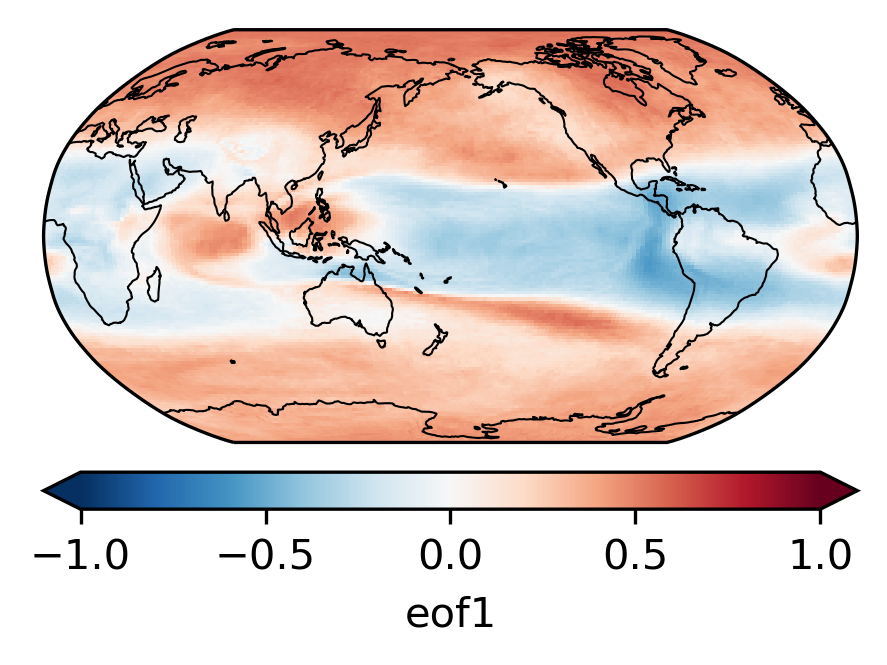

In [7]:
# show 1st eof on a map
fig = plt.figure(figsize=(3.5,2.625), dpi=300)

ax = plt.axes(projection=ccrs.Robinson(central_longitude=180, globe=None))
ax.set_global()
ax.coastlines(linewidth=0.5)

eof_cyclic, lon_plot = add_cyclic_point(-eofs[1,:,:], coord=lon)   

plt.pcolormesh(lon_plot,lat,eof_cyclic, cmap='RdBu_r',transform=ccrs.PlateCarree(central_longitude=0), vmin=-1, vmax=1)

plt.colorbar(label = 'eof1' ,orientation='horizontal',pad=0.05, extend='both')

In [8]:
lon_mean = dd.array.average(trop_conc,axis=2)
gm = dd.array.average(lon_mean,weights=lat_area_scaled,axis=1)
gm_plot = gm.compute()

In [88]:
ch4_ems_data = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/ubl949_ch4_oh_flux_PI.nc',chunks={'time':24})
ch4_ems = ch4_ems_data.variables[stash_ch4_oh]

ch4_ems_gm = np.mean(ch4_ems,axis=(1,2,3))
ems_fullmean = np.mean(ch4_ems_gm)

ems_anom = np.multiply(np.divide(ch4_ems_gm - ems_fullmean,ems_fullmean),100)

In [89]:
p_ems_anom = ems_anom.compute()

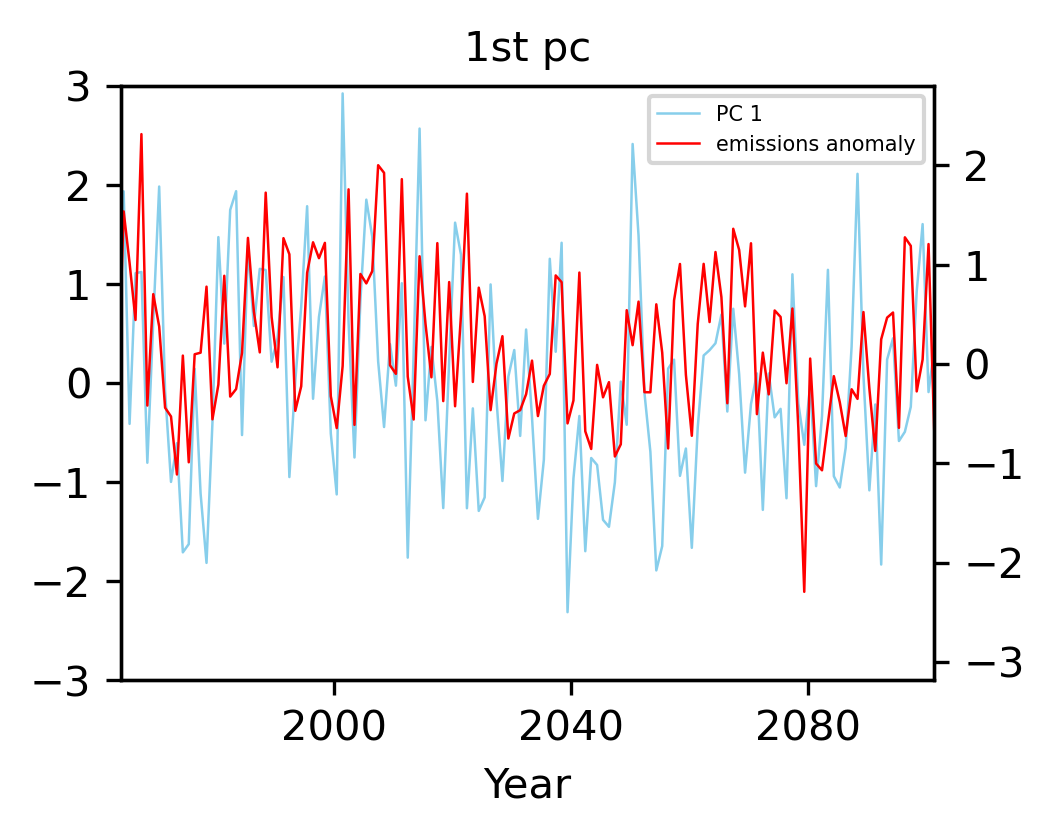

In [90]:
# Determine sign of time series by comparing to tropospheric OH

fig = plt.figure(figsize=(3.5,2.625), dpi=300)
ax = plt.axes()

plt.xlabel("Year")
ax.set_ylabel("", fontsize=8)
plt.title("1st pc", fontsize=10)
ax.set_xlim(-13000,36500)
ax.set_ylim(-3,3)

ax1 = ax.twinx()

line1, = ax1.plot(time_1, p_ems_anom, c='red',linewidth=0.6, label='emissions anomaly')
line0, = ax.plot(time_1, -pcs[:,1], c='skyblue', linewidth=0.6, label='PC 1')

ax.legend(handles=[line0,line1],fontsize=5,loc ='upper right')

In [91]:
fractions = solver.varianceFraction(neigs=5)
print(fractions)

[0.30474758 0.09453543 0.0718109  0.05289054 0.03474094]


In [95]:
from scipy.stats.stats import pearsonr
stat = pearsonr(pcs[:,2],p_ems_anom)

print(stat)

(0.007455410578981823, 0.8849762127484978)


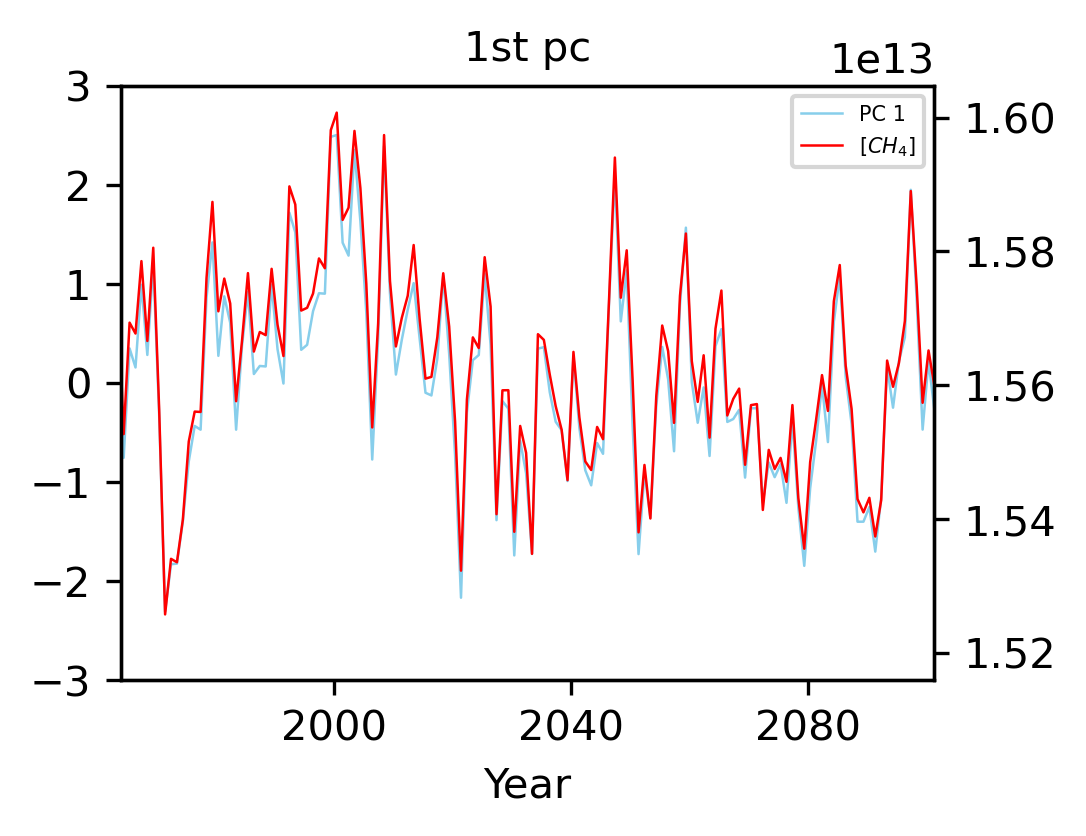

In [55]:
# Determine sign of time series by comparing to tropospheric OH

fig = plt.figure(figsize=(3.5,2.625), dpi=300)
ax = plt.axes()

plt.xlabel("Year")
ax.set_ylabel("", fontsize=8)
plt.title("1st pc", fontsize=10)
ax.set_xlim(-13000,36500)
ax.set_ylim(-3,3)

ax1 = ax.twinx()

line1, = ax1.plot(time_1, gm_plot, c='red',linewidth=0.6, label='$[CH_4]$')
line0, = ax.plot(time_1, -pcs[:,0], c='skyblue', linewidth=0.6, label='PC 1')

ax.legend(handles=[line0,line1],fontsize=5,loc ='upper right')